In [ ]:
# import importlib

# # # 1. 변경된 모듈을 평소처럼 import 합니다. (예: 'my_module.py'를 import)
# import db_handler 

# # # 2. 모듈의 내용이 변경되었다면, 아래 코드를 실행하여 다시 로드합니다.
# importlib.reload(db_handler)

<module 'db_handler' from 'c:\\DEV\\ZIP-FIT-2\\lab\\whatsup\\db_handler.py'>

In [ ]:
# !pip install dotenv BeautifulSoup4 requests pandas psycopg2 pgvector

In [ ]:
from db_handler import DataBaseHandler

In [ ]:
zf_db = DataBaseHandler()

with zf_db as cursor:
    query_create_table = """
    DROP TABLE IF EXISTS ANNC_LH_TEMP;
    CREATE TABLE IF NOT EXISTS ANNC_LH_TEMP (
        BATCH_ID UUID NOT NULL,               -- 배치 ID (UUID 타입)
        BATCH_SEQ INT NOT NULL,               -- 배치 SEQ
        ANNC_URL TEXT,                        -- 공고 URL (TEXT 타입)
        BATCH_STATUS_CD VARCHAR(10),          -- 배치 상태 코드 (VARCHAR(10))
        BATCH_START_DTTM TIMESTAMPTZ,         -- 배치 등록 시간 (TIMESTAMPTZ 타입, 시간대 포함)
        BATCH_END_DTTM TIMESTAMPTZ,           -- 배치 완료 시간 (TIMESTAMPTZ 타입, 시간대 포함)
        ANNC_TYPE VARCHAR(50),                -- 공고 유형 (VARCHAR(50))
        ANNC_REGION VARCHAR(50),              -- 지역 (VARCHAR(50))
        ANNC_PBLSH_DT VARCHAR(50),            -- 게시일 (VARCHAR(50))
        ANNC_DEADLINE_DT VARCHAR(50),         -- 마감일 (VARCHAR(50))
        ANNC_STATUS VARCHAR(20),              -- 공고 상태 (VARCHAR(20))
        LH_PAN_ID VARCHAR(50),                -- 공고 식별 ID (VARCHAR(50))
        LH_AIS_TP_CD VARCHAR(10),             -- 공고 유형 코드 (VARCHAR(10))
        LH_UPP_AIS_TP_CD VARCHAR(10),         -- 상위 공고 유형 코드 (VARCHAR(10))
        LH_CCR_CNNT_SYS_DS_CD VARCHAR(10),    -- 연계 시스템 구분 코드 (VARCHAR(10))
        LH_LS_SST VARCHAR(50),                -- 목록 상의 상태/순서 (VARCHAR(50)),
        PRIMARY KEY (BATCH_ID, BATCH_SEQ)     -- 기본 키: BATCH_ID와 BATCH_SEQ의 복합 키
    );
    """
    cursor.execute(query_create_table)
    # print(cursor.fetchone())

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import time
import os
import csv
import io

In [ ]:

# ==================================
# 1. 환경 설정 및 상수 정의
# ==================================

# 🚩 필터 기준: 게시일 >= 2024-11-01
START_DATE_FILTER = datetime(2024, 11, 1)
START_DATE_REQUEST = START_DATE_FILTER.strftime("%Y-%m-%d")

# 현재 날짜 (조회 종료일)
TODAY_DATE_REQUEST = datetime.now().strftime("%Y-%m-%d")

BASE_URL = "https://apply.lh.or.kr/lhapply/apply/wt/wrtanc/selectWrtancList.do"
DETAIL_URL_BASE = "https://apply.lh.or.kr/lhapply/apply/wt/wrtanc/selectWrtancInfo.do?mi=1026"

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36",
    "Referer": "https://apply.lh.or.kr/"
}

# Payload 템플릿
FORM_DATA_TEMPLATE = {
    'currPage': 1,
    'panId': '',
    'cnpCd': '',
    'prevListCo': 50,
    'srchAisTpCd': '',
    'panSs': '',
    'startDt': START_DATE_REQUEST,
    'endDt': TODAY_DATE_REQUEST,
    'aisTpCd': '',
    'uppAisTpCd': '',
    'mi': '',
    'srchUppAisTpCd': '',
    'srchY': 'N',
    'srchFilter': 'N',
    'csCd': '',
    'CNP_CD': '',
    'ccrCnntSysDsCd': '',
    'xssChk': 'N',
    'panEdDt': TODAY_DATE_REQUEST.replace('-', ''),
    'listCo': 100,
    'panNm': '',
    'indVal': 'N',
    'maxSn': 50,
    'mvinQf': '',
    'netbgn': '',
    'viewType': '',
    'panStDt': '',
    'minSn': 0,
    'schTy': '0',
    'page': 1,
}

# 🚩 임대/분양 유형 목록
LEASE_TYPES = [
    "통합공공임대", "통합공공임대(신혼희망)", "국민임대", "공공임대", "영구임대", "행복주택",
    "행복주택(신혼희망)", "장기전세", "신축다세대매입임대", "가정어린이집", "매입임대",
    "전세임대", "집주인임대", "6년 공공임대주택"
]

SALE_TYPES = [
    "분양주택", "공공분양(신혼희망)"
]

def generate_detail_url(anchor_tag):
    """HTML 요소에서 상세 페이지 조회에 필요한 data 속성을 추출하여 URL을 생성합니다."""
    data_panId = anchor_tag.get('data-id1', '')
    data_ccr = anchor_tag.get('data-id2', '')
    data_upp = anchor_tag.get('data-id3', '')
    data_ais = anchor_tag.get('data-id4', '')

    if not all([data_panId, data_ccr, data_upp, data_ais]):
        return ""

    url = (
        f"{DETAIL_URL_BASE}&"
        f"panId={data_panId}&"
        f"ccrCnntSysDsCd={data_ccr}&"
        f"uppAisTpCd={data_upp}&"
        f"aisTpCd={data_ais}"
    )
    return url

# ==================================
# 2. 크롤링 핵심 함수
# ==================================

def crawl_lh_notices_all_data():
    """LH 홈페이지에서 2024-11-01 이후의 모든 공고 데이터를 크롤링합니다."""
    all_data = []
    page = 1
    list_count = FORM_DATA_TEMPLATE['listCo']

    this_title = ""

    print("🚀 LH 공고 데이터 전체 크롤링 시작 (POST 방식)...")
    print(f"**필터 기준: [모든 유형] + 게시일 {FORM_DATA_TEMPLATE['startDt']} 이후 데이터 수집.**")

    while True:
        form_data = FORM_DATA_TEMPLATE.copy()
        form_data['currPage'] = str(page)
        form_data['page'] = str(page)
        form_data['minSn'] = str((page - 1) * list_count)
        form_data['maxSn'] = str(page * list_count)
        form_data['prevListCo'] = str(list_count)

        print(f"\n📄 Crawling page {page} ({form_data['minSn']} to {form_data['maxSn']})...")

        try:
            response = requests.post(BASE_URL, data=form_data, headers=HEADERS, timeout=15)
            response.raise_for_status()

            soup = BeautifulSoup(response.text, 'html.parser')
            rows = soup.select("div.bbs_ListA table tbody tr")
            raw_data_count = len(rows)

            if raw_data_count == 0:
                print("🏁 데이터 없음. 목록의 끝에 도달했습니다. 크롤링 종료.")
                break

            new_data_count = 0
            stop_crawling = False

            for row in rows:
                try:
                    cols = [c.get_text(strip=True) for c in row.select("td")]
                    if len(cols) < 9:
                        continue

                    status = cols[7]
                    post_date_str = cols[5]

                    try:
                        post_date = datetime.strptime(post_date_str, '%Y.%m.%d')
                        if post_date < START_DATE_FILTER:
                            print(f"🚩 게시일 {post_date_str} 데이터가 필터 기준({START_DATE_REQUEST})보다 이전입니다. 추가 크롤링을 중단합니다.")
                            stop_crawling = True
                            break
                    except ValueError:
                        pass

                    title_anchor = row.select_one("td:nth-child(3) a")
                    em_tag = title_anchor.find('em')
                    if em_tag:
                        em_tag.extract()
                    title = title_anchor.get_text(strip=True).replace('\n', ' ')

                    this_title = title

                    detail_url = generate_detail_url(title_anchor)

                    
                    if not detail_url:
                        continue

                    # 파일 정보 없는 경우 리턴
                    file_down_obj = row.select_one(".listFileDown")

                    if file_down_obj:
                        upp_ais_tp_cd = file_down_obj.get('data-id1', '')
                        ais_tp_cd = file_down_obj.get('data-id2', '')
                        ccr_cnnt_sys_ds_cd = file_down_obj.get('data-id3', '')
                        ls_sst = file_down_obj.get('data-id4', '')
                        pan_id = file_down_obj.get('data-id5', '')
                    else:
                        upp_ais_tp_cd = title_anchor.get('data-id3', '')
                        ais_tp_cd = title_anchor.get('data-id4', '')
                        ccr_cnnt_sys_ds_cd = title_anchor.get('data-id2', '')
                        ls_sst = ""
                        pan_id = title_anchor.get('data-id1', '')


                    all_data.append(
                        (
                            detail_url, # 공고 URL
                            cols[1], # 공고 유형
                            cols[3], # 지역
                            post_date_str, # 게시일
                            cols[6], # 마감일
                            status, # 공고 상태
                            pan_id, # 공고 식별 ID
                            ais_tp_cd, # 공고 유형 코드
                            upp_ais_tp_cd, # 상위 공고 유형 코드
                            ccr_cnnt_sys_ds_cd, # 연계 시스템 구분 코드
                            ls_sst, # 목록 상의 상태/순서
                        )
                    )


                    new_data_count += 1
                except Exception as e:
                    print(f"🚨 오류: {e} - {this_title}")
                    continue

            print(f"✅ 페이지 {page} 로드 성공. {len(rows)}개 중 {new_data_count}개 데이터 추출.")

            if stop_crawling or raw_data_count < list_count:
                print("🏁 크롤링 종료 조건 충족. 전체 크롤링 종료.")
                break

            page += 1
            time.sleep(1)

        except requests.exceptions.RequestException as e:
            print(f"🚨 네트워크 또는 HTTP 요청 오류 발생: {e}")
            break
        except Exception as e:
            print(f"🚨 치명적인 오류 발생: {e}")
            break

    if all_data:
        print(f"\n✨ 전체 크롤링 완료. 총 {len(all_data)}건의 데이터를 수집했습니다.")
        # return pd.DataFrame(all_data)
        return all_data
    else:
        print("🎉 완료! 수집된 데이터가 없습니다.")
        return []


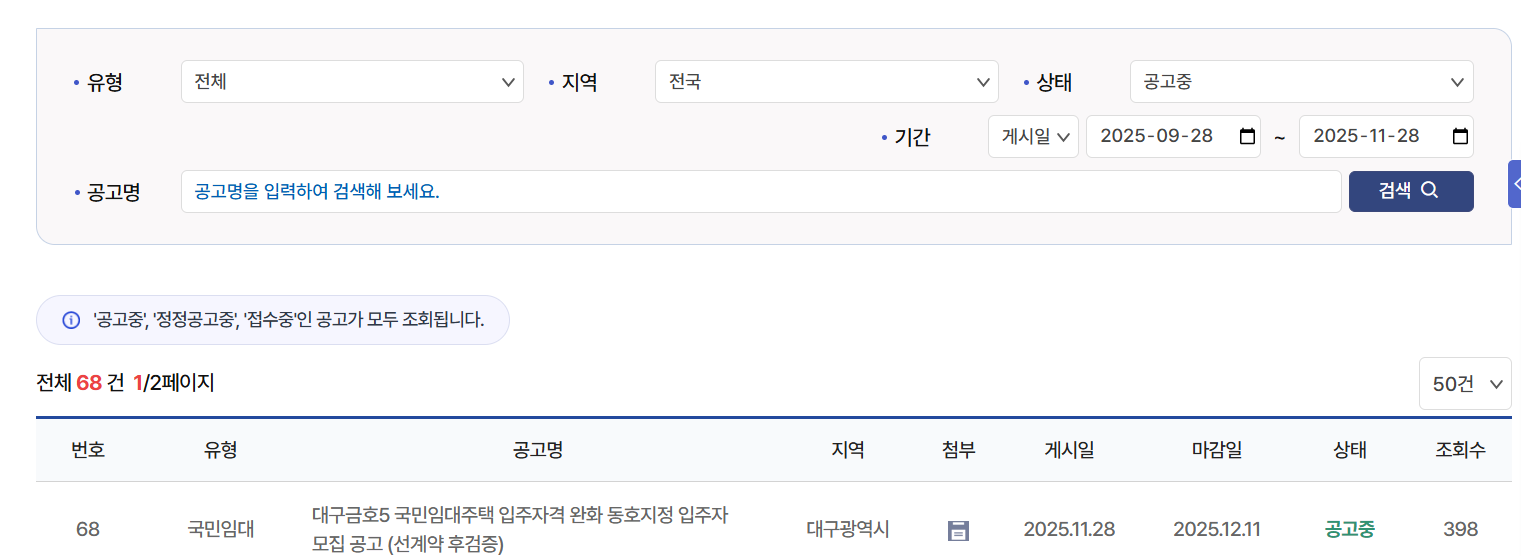

In [ ]:
df_all_notices = crawl_lh_notices_all_data()

🚀 LH 공고 데이터 전체 크롤링 시작 (POST 방식)...
**필터 기준: [모든 유형] + 게시일 2024-11-01 이후 데이터 수집.**

📄 Crawling page 1 (0 to 100)...
✅ 페이지 1 로드 성공. 100개 중 100개 데이터 추출.

📄 Crawling page 2 (100 to 200)...
✅ 페이지 2 로드 성공. 100개 중 100개 데이터 추출.

📄 Crawling page 3 (200 to 300)...
✅ 페이지 3 로드 성공. 100개 중 100개 데이터 추출.

📄 Crawling page 4 (300 to 400)...
✅ 페이지 4 로드 성공. 100개 중 100개 데이터 추출.

📄 Crawling page 5 (400 to 500)...
✅ 페이지 5 로드 성공. 100개 중 100개 데이터 추출.

📄 Crawling page 6 (500 to 600)...
✅ 페이지 6 로드 성공. 100개 중 100개 데이터 추출.

📄 Crawling page 7 (600 to 700)...
✅ 페이지 7 로드 성공. 100개 중 100개 데이터 추출.

📄 Crawling page 8 (700 to 800)...
✅ 페이지 8 로드 성공. 100개 중 100개 데이터 추출.

📄 Crawling page 9 (800 to 900)...
✅ 페이지 9 로드 성공. 100개 중 100개 데이터 추출.

📄 Crawling page 10 (900 to 1000)...
✅ 페이지 10 로드 성공. 100개 중 100개 데이터 추출.

📄 Crawling page 11 (1000 to 1100)...
✅ 페이지 11 로드 성공. 100개 중 100개 데이터 추출.

📄 Crawling page 12 (1100 to 1200)...
✅ 페이지 12 로드 성공. 100개 중 100개 데이터 추출.

📄 Crawling page 13 (1200 to 1300)...
✅ 페이지 13 로드 성공. 100개 중 100개 데이터

In [ ]:
# df_all_notices[0]

('https://apply.lh.or.kr/lhapply/apply/wt/wrtanc/selectWrtancInfo.do?mi=1026&panId=BN-0007282&ccrCnntSysDsCd=01&uppAisTpCd=01&aisTpCd=01',
 '토지',
 '충청북도',
 '2025.11.28',
 '2025.12.09',
 '공고중',
 'BN-0007282',
 '01',
 '01',
 '01',
 '')

In [ ]:
# df_all_notices
zf_db = DataBaseHandler()


zf_db.bulk_insert_lh_temp(df_all_notices)

✅ Psycopg2 벌크 삽입 성공! 3082개 데이터 삽입 완료.
   소요 시간: 1.6214 초


In [ ]:
# FILE_CALL_URL = "https://apply.lh.or.kr/lhapply/wt/wrtanc/wrtFileDownl.do"

# # df_all_notices.loc[0]
# form_data_file = {
#     'uppAisTpCd1': df_all_notices.loc[0]['upp_ais_tp_cd'],
#     'aisTpCd1': df_all_notices.loc[0]['ais_tp_cd'],
#     'ccrCnntSysDsCd1': df_all_notices.loc[0]['ccr_cnnt_sys_ds_cd'],
#     'lsSst1': df_all_notices.loc[0]['ls_sst'],
#     'panId1': df_all_notices.loc[0]['pan_id']
# }

# # 'upp_ais_tp_cd': upp_ais_tp_cd,
# # 'ais_tp_cd': ais_tp_cd,
# # 'ccr_cnnt_sys_ds_cd': ccr_cnnt_sys_ds_cd,
# # 'ls_sst': ls_sst,
# # 'pan_id': pan_id

# # <a class="listFileDown tbl_web2" data-id1="13" data-id2="26" data-id3="03" data-id4="" data-id5="2015122300019097" href="javascript:">

# response2 = requests.post(FILE_CALL_URL, data=form_data_file, headers=HEADERS, timeout=15)
# response2.encoding = 'utf-8'
# response2.raise_for_status()

# # soup2 = BeautifulSoup(response2.text, 'html.parser')

In [ ]:
# df_all_notices.loc[0]['URL']

'https://apply.lh.or.kr/lhapply/apply/wt/wrtanc/selectWrtancInfo.do?mi=1026&panId=2015122300019115&ccrCnntSysDsCd=03&uppAisTpCd=06&aisTpCd=07'

In [ ]:
# [
#     {
#         "cmnAhflSn": 64544108,
#         "slPanAhflDsCd": "17",
#         "slPanAhflDsCdNm": "공고문(hwp)",
#         "panId": "2015122300019115",
#         "ccrCnntSysDsCd": "03",
#         "cmnAhflNm": "251128대구금호5국민임대주택입주자격완화동호지정입주자모집공고.hwp",
#         "cmnPhyAhflNm": "2025112864544108.hwp",
#         "cmnAhflSz": 264192,
#         "cmnAhflPth": "/Files/upload_dec/2025/COM/11/28/",
#         "viewerFilePath": "P6YXl5MgPcH6JL4EFvwz%2FwLrGZse3REwH5qHkrK6VjeVCZfe89owOfMJq6Ko%2BzH3orVsD8eAoSIIZlLOlIFz9g%3D%3D",
#         "viewerFileNm": "GMIt%2B8WVkIQaQL7QBj%2FpR1SAAQIYRX75SrHk5JERMJK0ejDK%2F43w02bzhWaN9cDmunhWSvyoNINULablzVmuCypGWwa%2BZXbiAxXdotJbB5NrhXtYsI4lqQ69u748Guu%2B",
#         "sWebViewerExtYn": "Y",
#         "viewerFileExt": "TjcxjSOfx7si66o67%2BOZhw%3D%3D",
#     },
#     {
#         "cmnAhflSn": 64544146,
#         "slPanAhflDsCd": "01",
#         "slPanAhflDsCdNm": "공고문(PDF)",
#         "panId": "2015122300019115",
#         "ccrCnntSysDsCd": "03",
#         "cmnAhflNm": "251128대구금호5국민임대주택입주자격완화동호지정입주자모집공고.pdf",
#         "cmnPhyAhflNm": "2025112864544146.pdf",
#         "cmnAhflSz": 522371,
#         "cmnAhflPth": "/Files/upload_dec/2025/COM/11/28/",
#         "viewerFilePath": "P6YXl5MgPcH6JL4EFvwz%2FwLrGZse3REwH5qHkrK6Vjck5OZrN3XE7LTDZzWICHad6bk0BNWKKXgpO1txmy6ibw%3D%3D",
#         "viewerFileNm": "GMIt%2B8WVkIQaQL7QBj%2FpR1SAAQIYRX75SrHk5JERMJK0ejDK%2F43w02bzhWaN9cDmunhWSvyoNINULablzVmuCypGWwa%2BZXbiAxXdotJbB5Py75xjJBBNv9rXCi7N740Z",
#         "sWebViewerExtYn": "Y",
#         "viewerFileExt": "fmTeTHgEYAY6Q6iY9%2FtApA%3D%3D",
#     },
#     {
#         "cmnAhflSn": 64548660,
#         "slPanAhflDsCd": "02",
#         "slPanAhflDsCdNm": "카탈로그",
#         "panId": "2015122300019115",
#         "ccrCnntSysDsCd": "03",
#         "cmnAhflNm": "팜플렛(대구금호5단지).pdf",
#         "cmnPhyAhflNm": "2025112864548660.pdf",
#         "cmnAhflSz": 44762290,
#         "cmnAhflPth": "/Files/upload_dec/2025/COM/11/28/",
#         "viewerFilePath": "P6YXl5MgPcH6JL4EFvwz%2FwLrGZse3REwH5qHkrK6Vjd%2BQdBvqrwBvcHgKRox74zGG0ZyR0p7iuL3APLamGAgJA%3D%3D",
#         "viewerFileNm": "IMAbHje33ZVuv6aemA0X5ODEFqD1kGUYvpAqxczC24qZ31pxesK9NcvCqru7sgs4",
#         "sWebViewerExtYn": "Y",
#         "viewerFileExt": "fmTeTHgEYAY6Q6iY9%2FtApA%3D%3D",
#     },
#     {
#         "cmnAhflSn": 64548704,
#         "slPanAhflDsCd": "19",
#         "slPanAhflDsCdNm": "기타 첨부파일",
#         "panId": "2015122300019115",
#         "ccrCnntSysDsCd": "03",
#         "cmnAhflNm": "동의서등공사양식.zip",
#         "cmnPhyAhflNm": "2025112864548704.zip",
#         "cmnAhflSz": 353440,
#         "cmnAhflPth": "/Files/upload_dec/2025/COM/11/28/",
#         "viewerFilePath": "P6YXl5MgPcH6JL4EFvwz%2FwLrGZse3REwH5qHkrK6Vjc7SqMiD867QPvgOaR6Fd1Wcu2TvrMPKQIcBTbHFxWDHg%3D%3D",
#         "viewerFileNm": "VIqq1B3Y0l4JNcbOmuVzcdv8waFF70MyOvJV638uJdU%3D",
#         "sWebViewerExtYn": "N",
#         "viewerFileExt": "1p%2FPxqo8ok%2Fmjl9EflXnZQ%3D%3D",
#     },
# ]

In [ ]:
# download_url = 'https://apply.lh.or.kr/lhapply/lhFile.do?fileid=64544146'

# file_response = requests.get(
#     download_url,
#     stream=True,
#     timeout=30,
#     verify=False
# )
# file_response.raise_for_status()

# file_content = file_response.content
# actual_size = len(file_content)

c:\Users\Playdata\anaconda3\envs\zf2_back\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'apply.lh.or.kr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
# with open("251128대구금호5국민임대주택입주자격완화동호지정입주자모집공고.pdf", 'wb') as f:
#     f.write(file_content)

In [ ]:
# import uuid

# # 1. 고정할 UUID 정의
# # DB 트랜잭션 또는 일괄 삽입 작업을 위한 고정 UUID입니다.
# # str(uuid.uuid4())를 사용하면 매번 새로운 UUID가 생성되지만,
# # 여기서는 요청대로 '고정된' UUID를 사용하겠습니다.
# FIXED_UUID = 'uuid-sample-12345-uuid' 
# # 실제 사용 시에는 이 부분을 str(uuid.uuid4())로 대체하여 유일한 값을 생성할 수 있습니다.

# # 2. 편집 전 리스트 (크롤링 데이터)
# data_before = [
#     ('내용1', '내용1', '내용1'),
#     ('내용2', '내용2', '내용2'),
#     ('내용3', '내용3', '내용3'),
#     ('내용4', '내용4', '내용4'),
#     ('내용5', '내용5', '내용5')
# ]

# # 3. 리스트 컴프리헨션을 이용한 변환 (핵심 코드)
# # enumerate(data_before, 1)는 리스트의 항목과 1부터 시작하는 인덱스를 반환합니다.
# # 인덱스는 1부터 시작하도록 (1, item) 형태로 만듭니다.
# # 새로운 튜플을 만들 때는 (FIXED_UUID, index, *item) 형태로 언패킹(*)을 사용합니다.
# data_after = [
#     (FIXED_UUID, index, *item) 
#     for index, item in enumerate(data_before, 1)
# ]

# # 4. 결과 출력
# print("--- 편집 전 리스트 ---")
# for item in data_before:
#     print(item)

# print("\n--- 편집 후 리스트 (UUID와 Index 추가) ---")
# for item in data_after:
#     print(item)

--- 편집 전 리스트 ---
('내용1', '내용1', '내용1')
('내용2', '내용2', '내용2')
('내용3', '내용3', '내용3')
('내용4', '내용4', '내용4')
('내용5', '내용5', '내용5')

--- 편집 후 리스트 (UUID와 Index 추가) ---
('uuid-sample-12345-uuid', 1, '내용1', '내용1', '내용1')
('uuid-sample-12345-uuid', 2, '내용2', '내용2', '내용2')
('uuid-sample-12345-uuid', 3, '내용3', '내용3', '내용3')
('uuid-sample-12345-uuid', 4, '내용4', '내용4', '내용4')
('uuid-sample-12345-uuid', 5, '내용5', '내용5', '내용5')
